In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 16 13:26:00 2019

@author: GUOFENG
"""

import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

    # Set up 'ggplot' style


plt.style.use('ggplot')  # if want to use the default style, set 'classic'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family'] = 'Arial'

# .............................................................................


data = cifar10.load_data()
(trDat, trLbl) = data[0]
(tsDat, tsLbl) = data[1]

# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat = trDat.astype('float32') / 255
tsDat = tsDat.astype('float32') / 255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows = trDat.shape[1]
imgclms = trDat.shape[2]
channel = trDat.shape[3]

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl = to_categorical(trLbl)
tsLbl = to_categorical(tsLbl)
num_classes = tsLbl.shape[1]

# .............................................................................





In [2]:

# fix random seed for reproducibility
seed = 29
np.random.seed(seed)

optmz = optimizers.Adam(lr=0.001)
modelname = 'cifar10ResV1Cfg5'


# define the deep learning model


def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
  
    convLyr = Conv2D(numFilters,
                     kernel_size=kernelSz,
                     strides=strides,
                     padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4),
                     name=lyrName + '_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
        x = convLyr(x)
  
    return x


def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
  
    x = inputs
    for run in range(0, numBlocks):
        strides = 1
        blkStr = str(run + 1)
        
        if downsampleOnFirst and run == 0:
            strides = 2
            
        y = resLyr(inputs=x, numFilters=numFilters, strides=strides, lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y, numFilters=numFilters, activation=None, lyrName=names+'_Blk'+blkStr+'_Res2' if names else None) 
        
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x, numFilters=numFilters, kernelSz=1, 
                       strides=strides, activation=None, batchNorm=False, 
                       lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x = add([x, y], name=names+'_Blk'+blkStr+'_add' if names else None) 

        x = Activation('relu',  name=names+'_Blk'+blkStr+'_relu' if names else None)(x)   

    return x


def createResNetV1(inputShape=(32, 32, 3),
                   numClasses=10):
  
    inputs = Input(shape=inputShape)
    v = resLyr(inputs,
               lyrName='Inpt')
    v = resBlkV1(inputs=v,
                 numFilters=16,
                 numBlocks=3,
                 downsampleOnFirst=False,
                 names='Stg1')
    v = Dropout(0.3)(v)
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg2')
    v = Dropout(0.3)(v)
    v = resBlkV1(inputs=v,
                 numFilters=64,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg3')
    v = AveragePooling2D(pool_size=8,
                         name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numClasses,
                    activation='softmax',
                    kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optmz,
                  metrics=['accuracy'])
  
    return model

    # Setup the models


model = createResNetV1()  # This is meant for training
modelGo = createResNetV1()  # This is used for final testing

print(model.summary())


# .............................................................................

def lrSchedule(epoch):
    lr = 1e-3

    if epoch > 160:
        lr *= 0.5e-3

    elif epoch > 140:
        lr *= 1e-3

    elif epoch > 120:
        lr *= 1e-2

    elif epoch > 80:
        lr *= 1e-1

    print('Learning rate: ', lr)

    return lr


LRScheduler = LearningRateScheduler(lrSchedule)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 32, 32, 16)   64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 32, 32, 16)   0           Inpt_bn[0][0]                    
______________________________________________________________________________________________

Learning rate:  0.001
Epoch 1/200
1563/1562 - 40s - loss: 1.7023 - acc: 0.4394 - val_loss: 1.7859 - val_acc: 0.4756
Learning rate:  0.001
Epoch 2/200
1563/1562 - 30s - loss: 1.3640 - acc: 0.5649 - val_loss: 1.5747 - val_acc: 0.5439
Learning rate:  0.001
Epoch 3/200
1563/1562 - 31s - loss: 1.2130 - acc: 0.6215 - val_loss: 1.1003 - val_acc: 0.6683
Learning rate:  0.001
Epoch 4/200
1563/1562 - 30s - loss: 1.1263 - acc: 0.6543 - val_loss: 1.3295 - val_acc: 0.6145
Learning rate:  0.001
Epoch 5/200
1563/1562 - 30s - loss: 1.0527 - acc: 0.6818 - val_loss: 1.2148 - val_acc: 0.6476
Learning rate:  0.001
Epoch 6/200
1563/1562 - 29s - loss: 0.9983 - acc: 0.7052 - val_loss: 1.1612 - val_acc: 0.6735
Learning rate:  0.001
Epoch 7/200
1563/1562 - 30s - loss: 0.9550 - acc: 0.7192 - val_loss: 1.0108 - val_acc: 0.7082
Learning rate:  0.001
Epoch 8/200
1563/1562 - 30s - loss: 0.9243 - acc: 0.7334 - val_loss: 1.1985 - val_acc: 0.6692
Learning rate:  0.001
Epoch 9/200
1563/1562 - 30s - loss: 0.8959 - acc: 

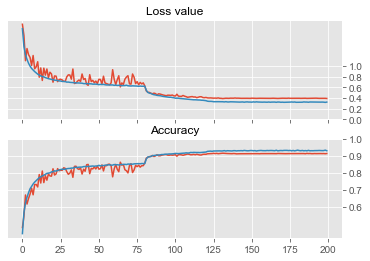

In [3]:
# Create checkpoint for the training
# This checkpoint performs model saving when
# an epoch gives highest testing accuracy
filepath = modelname + ".hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True,
                             mode='max')

# Log the epoch detail into csv
csv_logger = CSVLogger(modelname + '.csv')
callbacks_list = [checkpoint, csv_logger, LRScheduler]

# .............................................................................


# Fit the model
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             rotation_range=20,
                             horizontal_flip=True,
                             vertical_flip=False)

model.fit_generator(datagen.flow(trDat, trLbl, batch_size=32),
                    validation_data=(tsDat, tsLbl),
                    epochs=200,
                    verbose=2,
                    steps_per_epoch=len(trDat) / 32,
                    callbacks=callbacks_list)

# ......................................................................


# Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy',
                optimizer=optmz,
                metrics=['accuracy'])

# .......................................................................


# Make classification on the test dataset
predicts = modelGo.predict(tsDat)

# Prepare the classification output
# for the classification report
predout = np.argmax(predicts, axis=1)
testout = np.argmax(tsLbl, axis=1)
labelname = ['airplane',
             'automobile',
             'bird',
             'cat',
             'deer',
             'dog',
             'frog',
             'horse',
             'ship',
             'truck']
# the labels for the classfication report


testScores = metrics.accuracy_score(testout, predout)
confusion = metrics.confusion_matrix(testout, predout)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores * 100))
print(metrics.classification_report(testout, predout, target_names=labelname, digits=4))
print(confusion)

# ..................................................................

import pandas as pd

records = pd.read_csv(modelname + '.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0, 0.20, 0.40, 0.60, 0.80, 1.00])
plt.title('Loss value', fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Accuracy', fontsize=12)
plt.show()

from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file=modelname + '_model.pdf',
           show_shapes=True,
           show_layer_names=False,
           rankdir='TB')